In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import molbloom
import sqlite3
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
from IPython.display import display

In [11]:
from aizynthfinder.aizynthfinder import AiZynthFinder

finder = AiZynthFinder("config/config.yml")

In [12]:
finder.config.stock.selection = 'zinc'
finder.config.expansion_policy.selection = 'uspto'
finder.config.filter_policy.selection = 'uspto'
# finder.config.search.algorithm = "mcts"
# finder.config.scorers.selection = finder.config.scorers.items[0] 

In [13]:
# finder.config.search.algorithm_config["search_rewards"]

In [14]:
finder.config.search.time_limit = 5
finder.config.search.iteration_limit = 100
finder.config.search.max_transforms = 4
finder.config.search.return_first = False

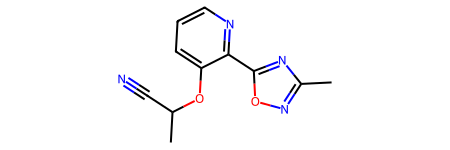

3.577486515045166

In [15]:
# smi = 'CC1=NC(CC(=O)N2CCC2(C)C)=C(C)S1'
# smi = 'CC(O)(CC1CCCCC1)C1CCCO1'
# smi = 'CCC(C#N)C1(O)CCC(C(O)=O)C(C)(C)C1'
# smi = 'CC(COCC1=C(C)C=NN1C)C1CC1'
smi = 'CC(OC1=CC=CN=C1C1=NC(C)=NO1)C#N'

display(Chem.MolFromSmiles(smi))

finder.target_smiles = smi
finder.prepare_tree()
finder.tree_search(show_progress=True)

In [16]:
rewards = finder.config.search.algorithm_config["search_rewards"] 
finder.build_routes(scorer=rewards)
print(len(finder.routes))

5


In [17]:
for route in finder.routes:
    print(route['route_metadata']['is_solved'])

True
True
True
False
False


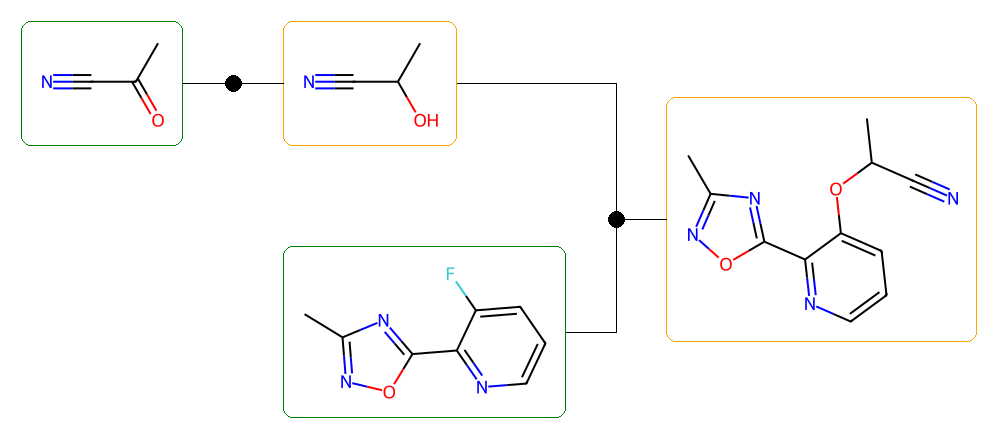

In [18]:
# print best route
finder.routes[0]['reaction_tree'].to_image()

In [19]:
finder.config.search.time_limit = 120
finder.config.search.iteration_limit = 1000
finder.config.search.max_transforms = 8
finder.config.search.return_first = True

def find_synthetic_route(smiles, show_route=False):
    finder.target_smiles = smiles
    finder.prepare_tree()
    finder.tree_search()
    
    rewards = finder.config.search.algorithm_config["search_rewards"] 
    finder.build_routes(scorer=rewards)
    
    for route in finder.routes:
        if route['route_metadata']['is_solved']:
            if show_route:
                display(route['reaction_tree'].to_image())
            return route
    
    return None

In [20]:
finder.routes[0]

{'reaction_tree': <aizynthfinder.reactiontree.ReactionTree at 0x1db348c6b90>,
 'route_metadata': {'created_at_iteration': 29, 'is_solved': True},
 'node': <aizynthfinder.search.mcts.node.MctsNode at 0x1db6ada1a80>,
 'score': {'state score': 0.994039853898894},
 'all_score': {'state score': 0.994039853898894}}

In [21]:
reactions = finder.routes[0]['reaction_tree'].reactions()
len(list(reactions))

2

In [22]:
finder.routes[0]['reaction_tree'].reactions()

<generator object ReactionTree.reactions at 0x000001DB6BFB93F0>

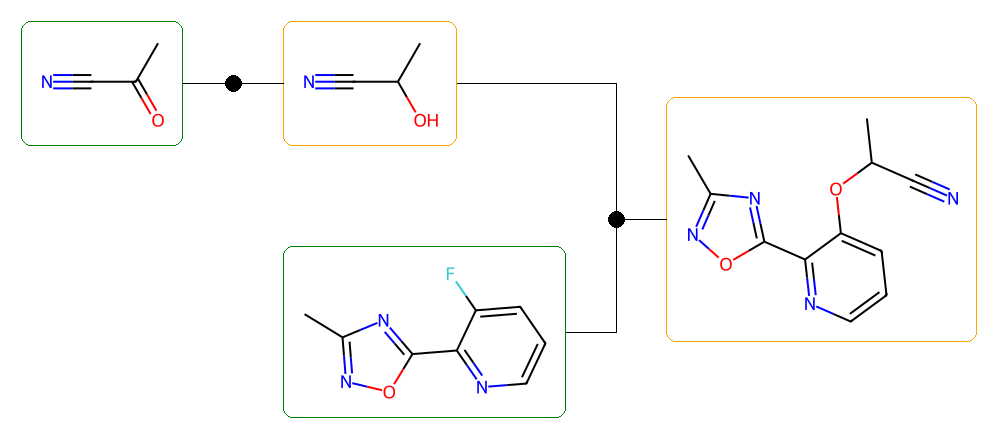

In [23]:
finder.routes[0]['reaction_tree'].to_image()

# Process batch of 1000 random samples from GDB17

In [25]:
import sqlite3
from src.utils import hash_dict

def create_run_tbl(conn):
    conn.execute('''
    CREATE TABLE IF NOT EXISTS runs (
        id INTEGER PRIMARY KEY,
        time_limit INTEGER,
        iteration_limit INTEGER,
        max_transforms INTEGER,        
        return_first BOOLEAN,
        stock TEXT,
        expansion_policy TEXT,
        filter_policy TEXT,
        hash TEXT
    )
    ''')


def search_run(run_config: dict, conn: sqlite3.Connection):
    run_hash = hash_dict(run_config)
    res = conn.execute('SELECT id FROM runs WHERE hash = ?', (run_hash,)).fetchone()
    if res:
        return res[0]
    else:
        return None

def get_new_run_id(conn: sqlite3.Connection):
    res = conn.execute('SELECT COUNT(id) FROM runs').fetchone()[0]
    return res

def add_new_run(run_config: dict, conn: sqlite3.Connection) -> int:
    run_id = get_new_run_id(conn)
    sql = "INSERT INTO runs VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)"              
    run_hash = hash_dict(run_config)
    args = (
        run_id,
        run_config['time_limit'],
        run_config['iteration_limit'],                 
        run_config['max_transforms'],
        run_config['return_first'],
        run_config['stock'],
        run_config['expansion_policy'],                  
        run_config['filter_policy'], 
        run_hash
    )
    conn.execute(sql, args)
    return run_id
    
def run_to_db(run_config, db_path='results.db') -> int:
    with sqlite3.connect(db_path) as conn:    
        create_run_tbl(conn)
        
        run_id = search_run(run_config, conn)        
        if run_id is not None:
            print('Run found: run_id', run_id)
            return run_id
                        
        run_id = add_new_run(run_config, conn)
        print('New run created: run_id', run_id)
        return run_id
    

In [26]:
def create_routes_tbl(conn):
    conn.execute('''
    CREATE TABLE IF NOT EXISTS routes (
        id INTEGER PRIMARY KEY,
        run_id INTEGER NOT NULL,
        smi TEXT NOT NULL,
        solved BOOLEAN,
        num_steps INTEGER,
        score FLOAT,
        tree_dict TEXT
    )
    ''')
    
def route_exists(smi, run_id, conn):
    return conn.execute(f'SELECT EXISTS(SELECT 1 FROM routes WHERE smi="{smi}" AND run_id={run_id});').fetchone()[0]

def write_synthetic_route(smi, route, run_id, conn):
    tree_dict = route['reaction_tree'].to_dict()
    score = route['score']['state score']            
    
    reactions = finder.routes[0]['reaction_tree'].reactions()
    num_steps = len(list(reactions))
    sql = f'''
        INSERT INTO routes (run_id, smi, solved, score, num_steps, tree_dict) 
        VALUES ({run_id}, "{smi}", {solved}, {score}, {num_steps} ,"{tree_dict}")
    '''
    conn.execute(sql)

def write_failed_route(smi, run_id, conn):
    sql = f'''
        INSERT INTO routes (run_id, smi, solved) 
        VALUES ({run_id}, "{smi}", {False})
    '''
    conn.execute(sql)

def set_finder_config(finder, run_config):
    finder.config.stock.selection = run_config['stock']
    finder.config.expansion_policy.selection = run_config['expansion_policy']
    finder.config.filter_policy.selection = run_config['filter_policy']
    
    finder.config.search.time_limit = run_config['time_limit']
    finder.config.search.iteration_limit = run_config['iteration_limit']
    finder.config.search.max_transforms = run_config['max_transforms']
    finder.config.search.return_first = run_config['return_first']
    

In [ ]:
with sqlite3.connect('results.db') as conn:
    create_run_tbl(conn)
    create_routes_tbl(conn)

In [28]:
# smiles = pd.read_csv('data/rscores_max_2.smi', header=None)
# smiles = pd.read_csv('data/100_rnd.smi', header=None)[0]
smiles = pd.read_csv('data/1000_rnd.smi', header=None)[0]

run_config = {
    'time_limit': 300,
    'iteration_limit': 5000,
    'max_transforms': 8,
    'return_first': False,
    'stock': 'zinc',
    'expansion_policy': 'uspto',
    'filter_policy': 'uspto',
}

set_finder_config(finder, run_config)

run_id = run_to_db(run_config)

pbar = tqdm(total=len(smiles), position=0, leave=True)
for smi in smiles:    
    try:
        with (sqlite3.connect('results.db') as conn):            
            if route_exists(smi, run_id, conn):
                pbar.update(1)
                continue
            
            route = find_synthetic_route(smi)
            solved = route is not None
            
            if solved:
                write_synthetic_route(smi, route, run_id, conn)
            else:
                write_failed_route(smi, run_id, conn)
            pbar.update(1)
            
    except Exception as e:
        print('Exception:', e)

Run found: run_id 1


  5%|▍         | 46/1000 [03:16<1:21:09,  5.10s/it]

KeyboardInterrupt: 

In [26]:
# Test multiprocessing